<a href="https://colab.research.google.com/github/Liping-LZ/BDAO_ECDA/blob/main/Text%20analysis/keyword_extraction_product_description.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving amazon_products.xlsx to amazon_products.xlsx


In [ ]:
import pandas as pd
df = pd.read_excel('amazon_products.xlsx')
df.head()

,product_id,product_name,category,about_product
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories|Accessories&Peripherals|...,High Compatibility : Compatible With iPhone 12...
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories|Accessories&Peripherals|...,"Compatible with all Type C enabled devices, be..."
2,B096MSW6CT,Sounce Fast Phone Charging Cable & Data Sync U...,Computers&Accessories|Accessories&Peripherals|...,ã€ Fast Charger& Data Syncã€‘-With built-in s...
3,B08HDJ86NZ,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Computers&Accessories|Accessories&Peripherals|...,The boAt Deuce USB 300 2 in 1 cable is compati...
4,B08CF3B7N1,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Computers&Accessories|Accessories&Peripherals|...,[CHARGE & SYNC FUNCTION]- This cable comes wit...


In [ ]:
target_column = "about_product"

In [ ]:
!pip install contractions
import re
import contractions
import string

df[target_column] = df.about_product.str.lower()


df[target_column] = df[target_column].map(lambda x: contractions.fix(x))


# Remove new line characters ("/n")
df[target_column] = df[target_column].map(lambda x: re.sub('\s+', ' ', x))

# Remove url link
df[target_column] = df[target_column].apply(lambda x: re.sub('http://\S+|https://\S+', '', x))

# Remove numbers
df[target_column] = df[target_column].map(lambda x: re.sub(r"\d+", ' ', x))

# Remove overspace
df[target_column] = df[target_column].map(lambda x: re.sub('\s{2,}', " ", x))

# Remove punctuation
df[target_column] = df[target_column].map(lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x))

# Remove special characters
df[target_column] = df[target_column].map(lambda x: re.sub('\W+',' ', x))

In [ ]:
import nltk
nltk.download('punkt')

# create a list of the products from the 'product' column
words = df[target_column].tolist()

# tokenise the words
from nltk.tokenize import word_tokenize

word_tokens = [] # create an empty list to put the tokenised words
for product in words:
    word_tokens.append(word_tokenize(product))

# Start dealing with stopwords
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
# use English stopwords
stopwords = stopwords.words("english")
# you can also extend the stopwords list with more words that you want to remove
stopwords.extend(['re'])

# create a new list with stop words removed
tokens_without_stopwords = []
for product in word_tokens:
    tokens_without_stopwords.append([w for w in product if not w in stopwords])


nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# The lemmatizer requires the correct POS tag to be accurate, if you use the default settings of the WordNetLemmatizer.lemmatize(), the default tag is noun.
# Which means the words other than noun would not be lemmatised, and this is not what we expect.
# Therefore we need to define the POS tags ('n' for nouns(default), 'a' for adj, 'v' for verb, 'r' for adverb) which are allowed to be lemmatised.

lemmatised = []
for product in tokens_without_stopwords:
  n_lemmatised = [lemmatizer.lemmatize(w) for w in product]
  v_lemmatised = [lemmatizer.lemmatize(w,'v') for w in n_lemmatised]
  r_lemmatised = [lemmatizer.lemmatize(w,'r') for w in v_lemmatised]
  a_lemmatised = [lemmatizer.lemmatize(w,'a') for w in r_lemmatised]
  lemmatised.append(a_lemmatised) # here noun, adj, verb, adv are the POS tags that we allowed


# put the tokens back together as text after lemmatisation
import string
rejoin = []
for product in lemmatised:
    x = " ".join(product) # join the text back together
    # remove punctuation from the reviews using the string package
    rejoin.append(x)

# add the reformed text to the data frame
df['filtered_product_description'] = rejoin

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
df['filtered_product_description'].head()

0    high compatibility compatible iphone x xsmax x...
1    compatible type c enable device android smartp...
2    ã fast charger data syncã build safety proctec...
3    boat deuce usb cable compatible smartphones ta...
4    charge sync function cable come charge data sy...
Name: filtered_product_description, dtype: object

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# set vectorizer - CountVectorizer for word counts
tfidfvectorizer = TfidfVectorizer()

tfidf = tfidfvectorizer.fit_transform(df.filtered_product_description).toarray()
vocab = tfidfvectorizer.vocabulary_
reverse_vocab = {v:k for k,v in vocab.items()}

feature_names = tfidfvectorizer.get_feature_names_out()
df_tfidf = pd.DataFrame(tfidf, columns = feature_names)

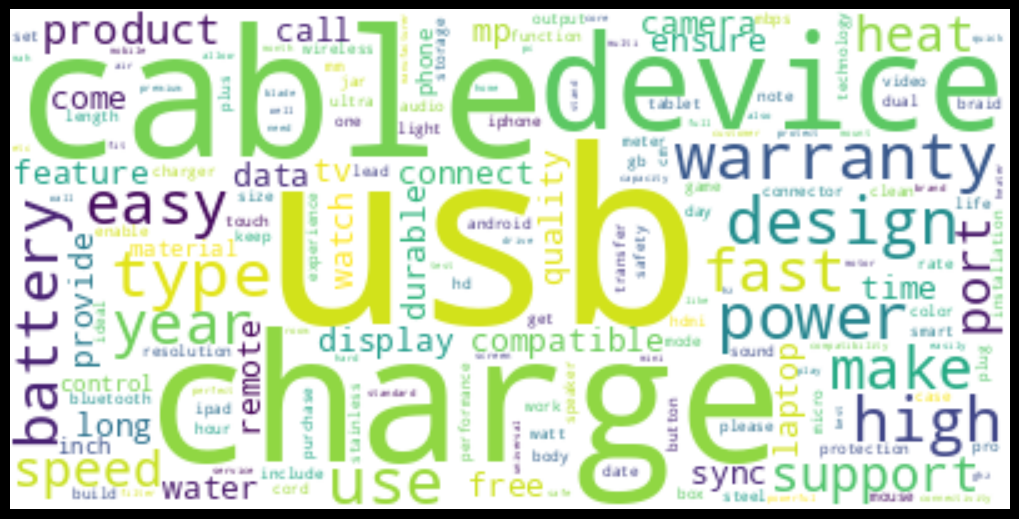

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud(background_color="white", max_words=500).generate_from_frequencies(df_tfidf.T.sum(axis=1))
plt.figure(figsize=(10,5),facecolor ='k')
plt.imshow(wordcloud, interpolation ='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [ ]:
idx = tfidf.argsort(axis=1)

tfidf_max10 = idx[:,-10:]

df_tfidf['top10'] = [[reverse_vocab.get(item) for item in row] for row in tfidf_max10 ]

tfidf_top = df.join(df_tfidf['top10'], how='left')
# write the dataframe out to csv and download
tfidf_top.to_csv('tfidf_top.csv',index=False)
files.download('tfidf_top.csv')